In [1]:
# two approaches
# 1. Latent Dirichlet Allocation (LDA)
# 2. Non-Negative Matrix Factorization (NMF)

In [2]:
import os
os.system('export LC_ALL=en_US.UTF-8')
os.system('export LANG=en_US.UTF-8')

0

In [3]:
# imports
import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation, NMF
%matplotlib inline

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varunn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# read data
local_data_root = os.getcwd()
files = os.listdir(local_data_root)
df_files = [local_data_root+'/'+x for x in files if (x.startswith('t')) & (x.endswith('.zip'))]
print df_files

['/Users/varunn/Documents/kaggle/test.zip', '/Users/varunn/Documents/kaggle/train.zip']


In [6]:
data = {}
for fn in df_files:
    print 'unzip file: %s' % (fn)
    os.system('unzip {}'.format(fn))
    name = fn.split('.')[0]
    name = name.split('/')[-1]
    print 'reading file: %s' % (name+'.csv')
    df = pd.read_csv(local_data_root+'/'+name+'.csv')
    data[name] = df

unzip file: /Users/varunn/Documents/kaggle/test.zip
reading file: test.csv
unzip file: /Users/varunn/Documents/kaggle/train.zip
reading file: train.csv


In [7]:
data.keys()

['test', 'train']

In [8]:
data['train'].shape

(19579, 3)

In [9]:
print data['train'].head()

        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL


In [10]:
print data['train']['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


In [11]:
print data['train']['text'][0]

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.


In [12]:
train = data['train'].copy()

In [13]:
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='nathanv',api_key='YosfDr5VHlrzjtOJER8j')
import plotly.graph_objs as go
import plotly.tools as tls
tls.embed('https://plot.ly/~cufflinks/8')

In [14]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

In [15]:
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [16]:
all_words = train['text'].str.split(expand=True)

In [17]:
print type(all_words)
print all_words.shape
print all_words.head()

<class 'pandas.core.frame.DataFrame'>
(19579, 861)
       0         1         2         3     4      5       6               7    \
0     This  process,  however,  afforded    me     no   means              of   
1       It     never      once  occurred    to     me    that             the   
2       In       his      left      hand   was      a    gold           snuff   
3      How    lovely        is    spring    As     we  looked            from   
4  Finding   nothing     else,       not  even  gold,     the  Superintendent   

            8        9    ...    851   852   853   854   855   856   857  \
0  ascertaining      the  ...   None  None  None  None  None  None  None   
1      fumbling    might  ...   None  None  None  None  None  None  None   
2          box,     from  ...   None  None  None  None  None  None  None   
3       Windsor  Terrace  ...   None  None  None  None  None  None  None   
4     abandoned      his  ...   None  None  None  None  None  None  None   

    8

In [18]:
all_words = train['text'].str.split(expand=True).unstack()

In [19]:
print type(all_words)
print all_words.shape
print all_words.head()

<class 'pandas.core.series.Series'>
(16857519,)
0  0       This
   1         It
   2         In
   3        How
   4    Finding
dtype: object


In [20]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()

In [21]:
print type(all_words)
print all_words.shape
print all_words.head()
print all_words[2:50]

<class 'pandas.core.series.Series'>
(47556,)
the    33296
of     20851
and    17059
to     12615
I      10382
dtype: int64
and      17059
to       12615
I        10382
a        10359
in        8787
was       6440
that      5988
my        5037
had       4324
with      4207
his       3802
as        3528
he        3422
it        3247
for       3227
which     3203
not       3048
at        2925
from      2758
by        2725
is        2533
but       2521
on        2285
be        2268
The       2121
were      2118
have      2089
me        2015
this      2007
her       1953
all       1691
or        1679
an        1644
no        1500
you       1428
so        1395
been      1373
one       1372
we        1347
upon      1308
could     1259
its       1215
would     1202
when      1178
they      1134
their     1104
more      1100
him       1036
dtype: int64


In [22]:
data = [go.Bar(
    x=all_words.index.values[2:50],
    y=all_words.values[2:50],
    marker=dict(colorscale='Jet', color=all_words.values[2:50]),
    text='Word Counts')]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

WordCloud to visualize each author's work

In [23]:
print train.columns

Index([u'id', u'text', u'author'], dtype='object')


In [24]:
print train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


In [25]:
eap = train[train['author'] == 'EAP']['text'].values
mws = train[train['author'] == 'MWS']['text'].values
hpl = train[train['author'] == 'HPL']['text'].values

In [26]:
print len(eap), len(mws), len(hpl), type(hpl)

7900 6044 5635 <type 'numpy.ndarray'>


In [27]:
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

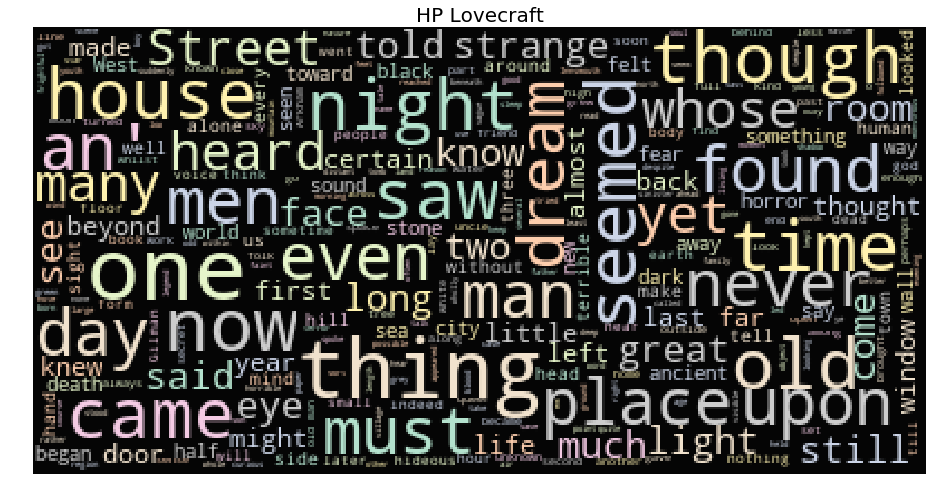

In [29]:
# The wordcloud for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

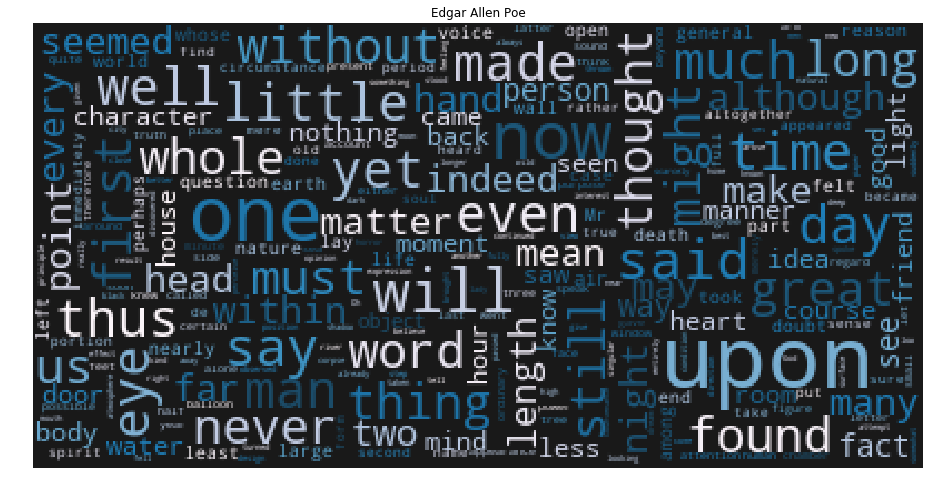

In [30]:
# wordcloud for Edgar Allen Poe
plt.figure(figsize=(20,18))
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

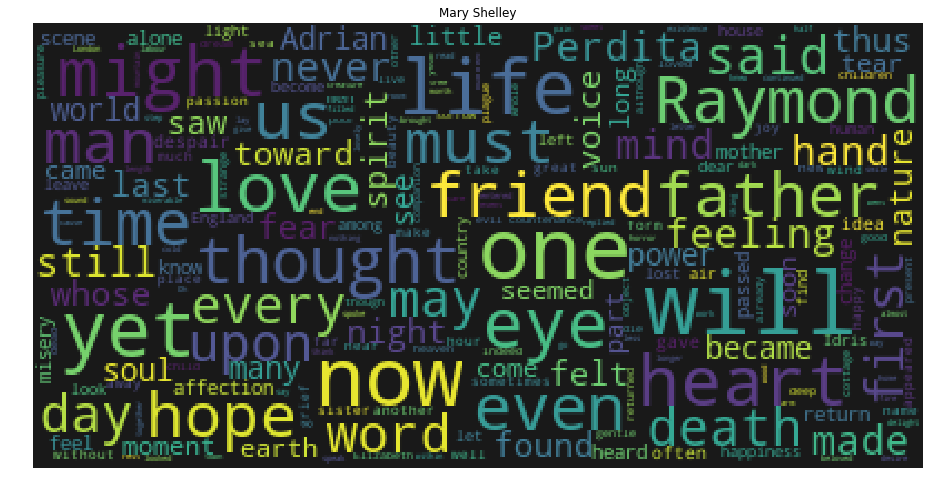

In [31]:
# wordcloud for Mary Shelley
plt.figure(figsize=(20,18))
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley")
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

Preprocessing

In [45]:
# tokenization
import nltk
nltk.download('punkt')
import string

[nltk_data] Downloading package punkt to /Users/varunn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
first_text = train['text'].values[0]

In [55]:
print first_text
print '='*110
print first_text.split(' ')
print '='*110
first_text_tokenized = nltk.word_tokenize(first_text)
print first_text_tokenized
print '='*110
first_text_tokenized_Wpunkt = [x for x in first_text_tokenized if x not in string.punctuation]
print first_text_tokenized_Wpunkt
print '='*110
first_text_tokenized_Wpunkt_Wstop = [x for x in first_text_tokenized_Wpunkt if x not in eng_stopwords]
print first_text_tokenized_Wpunkt_Wstop
print '='*110
print 'length of original text: %d' % (len(first_text_tokenized))
print 'length of text post removal of punctuation: %d' % (len(first_text_tokenized_Wpunkt))
print 'length of text post removal of stopwords and punctuation: %d' % (len(first_text_tokenized_Wpunkt_Wstop))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']
['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']
['This', 'process', 'however

In [51]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
# stemming and lematization

In [65]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/varunn/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [66]:
base_char = 'The stemmed form of {} is {}'

In [67]:
print base_char.format('running', PorterStemmer().stem('running'))
print base_char.format('runs', PorterStemmer().stem('runs'))
print base_char.format('run', PorterStemmer().stem('run'))
print base_char.format('ran', PorterStemmer().stem('ran'))
print base_char.format('leaves', PorterStemmer().stem('leaves'))

The stemmed form of running is run
The stemmed form of runs is run
The stemmed form of run is run
The stemmed form of ran is ran
The stemmed form of leaves is leav


In [68]:
print base_char.format('running', WordNetLemmatizer().lemmatize('running'))
print base_char.format('runs', WordNetLemmatizer().lemmatize('runs'))
print base_char.format('run', WordNetLemmatizer().lemmatize('run'))
print base_char.format('ran', WordNetLemmatizer().lemmatize('ran'))
print base_char.format('leaves', WordNetLemmatizer().lemmatize('leaves'))

The stemmed form of running is running
The stemmed form of runs is run
The stemmed form of run is run
The stemmed form of ran is ran
The stemmed form of leaves is leaf


vectorizing text

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

In [70]:
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]

In [71]:
vectorizer = CountVectorizer(min_df=0)
sentence_t = vectorizer.fit_transform(sentence)

In [74]:
print sentence_t.toarray()

[[1 1 0 1 1]
 [0 1 1 1 1]]


In [75]:
print vectorizer.get_feature_names()

[u'burgers', u'eat', u'fries', u'love', u'to']


Topic Modelling via LDA and NMF

In [142]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = '\nTopic #{}:'.format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1: -1]])
        print message
        print '='*70

In [77]:
# sklearn's countvectroizer class does tokenizing and stopwords removal by removing terms with single characters.
# It also lower cases all terms by default

In [78]:
# Extending the CountVectorizer class with a lemmatizer

In [79]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [83]:
text = train.text.values.tolist()

In [85]:
print len(text)
print text[0]

19579
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.


In [86]:
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', decode_error='ignore')

In [87]:
tf = tf_vectorizer.fit_transform(text)

In [90]:
tf_values = tf.toarray()

In [94]:
print type(tf_values)
print len(tf_values)
print tf_values[0]
print len(tf_values[0])
print tf_vectorizer.get_feature_names()[:5]

<type 'numpy.ndarray'>
19579
[0 0 0 ... 0 0 0]
13781
[u'aback', u'abandon', u'abandoned', u'abandoning', u'abandonment']


In [97]:
# top 50 words in terms of frequencies

In [108]:
feat_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()

In [110]:
zipped = list(zip(feat_names, count_vec))

In [112]:
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)

In [121]:
for x in zip(*zipped):
    print list(x)

[u'time', u'man', u'day', u'thing', u'eye', u'said', u'did', u'old', u'like', u'life', u'night', u'thought', u'little', u'great', u'long', u'saw', u'say', u'house', u'came', u'hand', u'year', u'word', u'death', u'heart', u'mind', u'place', u'friend', u'far', u'know', u'shall', u'heard', u'men', u'light', u'left', u'door', u'felt', u'room', u'love', u'come', u'earth', u'hour', u'world', u'head', u'way', u'voice', u'make', u'moment', u'fear', u'let', u'having', u'away', u'dream', u'nature', u'father', u'body', u'strange', u'seen', u'good', u'length', u'human', u'hope', u'knew', u'raymond', u'soon', u'face', u'sea', u'city', u'half', u'new', u'water', u'street', u'spirit', u'air', u'foot', u'idea', u'soul', u'form', u'point', u'sound', u'mean', u'just', u'wall', u'gave', u'mr', u'window', u'horror', u'object', u'child', u'feeling', u'looked', u'small', u'near', u'young', u'matter', u'took', u'end', u'look', u'dark', u'person', u'power', u'certain', u'course', u'passed', u'lay', u'open', u

In [116]:
x = []
y = []
for item in zipped:
    x.append(item[0])
    y.append(item[1])

In [117]:
print x[:5]
print y[:5]

[u'time', u'man', u'day', u'thing', u'eye']
[869, 779, 743, 725, 707]


In [122]:
x, y = (list(x) for x in zip(*zipped))

In [126]:
print x[:5]
print y[:5]
print len(x)

[u'time', u'man', u'day', u'thing', u'eye']
[869, 779, 743, 725, 707]
13781


In [128]:
X = np.concatenate([x[0:15], x[-16:-1]])
Y = np.concatenate([y[0:15], y[-16:-1]])
print X
print Y

[u'time' u'man' u'day' u'thing' u'eye' u'said' u'did' u'old' u'like'
 u'life' u'night' u'thought' u'little' u'great' u'long' u'yath' u'yea'
 u'yelling' u'yoke' u'yorktown' u'youngish' u'yule' u'yuletide' u'zaimi'
 u'zar' u'zerubbabel' u'zigzag' u'zigzagging' u'zodiacal' u'\xe6dile']
[869 779 743 725 707 704 700 616 613 609 586 576 531 512 511   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2]


In [130]:
# plot top 50 word frequencies
data = [go.Bar(
    x = x[:50],
    y = y[:50],
    marker = dict(colorscale='Jet', color=y[:50]),
    text = 'Word Counts'
)]
layout = go.Layout(title='Top 50 Word frequencies after Preprocessing')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [131]:
# bottom 100 word frequencies
data = [go.Bar(
    x = x[-100:],
    y = y[-100:],
    marker = dict(colorscale='Jet', color=y[-100:]),
    text = 'Word Counts')]
layout = go.Layout(title='Bottom 100 word frequencies after preprocessing')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [132]:
# Latent Dirichlet Allocation

In [133]:
# parameters to tune = n_components (number of topics), alpha (dirichlet prior for document-topic), beta (dirichlet prior for topic-word prior)

In [135]:
# n_components is identified based on KMeans + Latent Semantic Analysis Scheme
# whereby the number of Kmeans clusters and number of LSA dimensions were iterated through and the best silhouette mean score

In [136]:
from sklearn.decomposition import LatentDirichletAllocation

In [137]:
lda = LatentDirichletAllocation(n_components=11, learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [138]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=11, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [143]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:mean fact night return great young looking countenance wonder human difficulty greater set wife finally possessed regard society struck act perceived law health mr key fearful evidence exceedingly carried lady home write recall accident various force proved poet neck conduct

Topic #1:death love raymond hope heart child word went spirit good time ground evil man life long misery replied filled passion bed despair happiness till memory grief heavy escape region visit story beauty doe year die plague influence power thou making

Topic #2:left said let hand took say little length body air great secret right gave having arm character minute thousand foot true discovered self gentleman pleasure point box clock pain sought case nearly course best mere manner head balloon going madame

Topic #3:called sense table suddenly sympathy machine sens suppose labour unusual mist thrown solution movement stage frequent whispered specie urged place wine turk ring appear

In [144]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [146]:
print len(first_topic)
print len(second_topic)

13781
13781


In [147]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [148]:
print first_topic_words

[u'mean', u'fact', u'night', u'return', u'great', u'young', u'looking', u'countenance', u'wonder', u'human', u'difficulty', u'greater', u'set', u'wife', u'finally', u'possessed', u'regard', u'society', u'struck', u'act', u'perceived', u'law', u'health', u'mr', u'key', u'fearful', u'evidence', u'exceedingly', u'carried', u'lady', u'home', u'write', u'recall', u'accident', u'various', u'force', u'proved', u'poet', u'neck', u'conduct', u'investigation', u'aware', u'doctor', u'gate', u'cat', u'host', u'really', u'simple', u'altogether', u'operation']


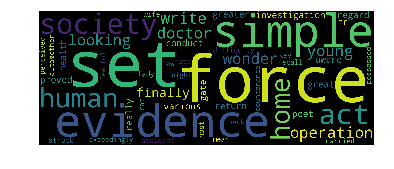

In [149]:
firstcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500, height=1000).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

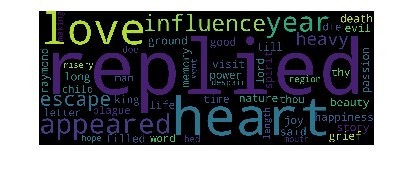

In [150]:
secondcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=2500, height=1000).generate(" ".join(second_topic_words)
                                                                                                        )
plt.imshow(secondcloud)
plt.axis('off')
plt.show()